# Email spam classification using BERT


In [1]:
#get imports and dependencies
!pip install transformers
import torch
import torch.nn as nn
import pandas as pd

In [2]:
#get data
training_file_name = 'https://raw.githubusercontent.com/Mahmoud5Saad/spam_detection_using_cohere/main/email_class_data/SMS_train%20-%20SMS_train.csv'
test_file_name = 'https://raw.githubusercontent.com/Mahmoud5Saad/spam_detection_using_cohere/main/email_class_data/SMS_test%20-%20SMS_test.csv'
label_column_name = 'Labels'
text_column_name = 'Examples'
df = pd.read_csv(training_file_name)
df_test = pd.read_csv(test_file_name)

In [3]:
df[label_column_name].unique()

array(['Non-Spam', 'Spam'], dtype=object)

In [4]:
df[label_column_name].value_counts()

Non-Spam    835
Spam        122
Name: Labels, dtype: int64

In [5]:
df[label_column_name].value_counts()/len(df)

Non-Spam    0.872518
Spam        0.127482
Name: Labels, dtype: float64

In [6]:
#df_sample = pd.concat([df[df["labels"] == "neutral"].sample(5),df[df["labels"] == "positive"].sample(5),df[df["labels"] == "negative"].sample(5)])

In [7]:
from sklearn.model_selection import train_test_split

VERBOSE = True

df_train,  df_validation = train_test_split(df, test_size=0.2, random_state=42, stratify=df[label_column_name])


if VERBOSE:
  print("training count: ", len(df_train))
  print("validation count: ", len(df_validation))
  print("test count: ", len(df_test))

training count:  765
validation count:  192
test count:  125


In [8]:
#get pretrained model
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
if torch.cuda.is_available():
  CUDA = True
  print("running on GPU!")
  !nvidia-smi
else:
  CUDA = False

running on GPU!
Sun Oct  9 18:13:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

In [10]:
class Net(nn.Module):
  def __init__(self, base_model):
    super().__init__()
    self.base_model = base_model
    if CUDA:
      model.to("cuda:0")
      self.clf_head = nn.Sequential(nn.Linear(768, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, 2)).to("cuda:0")
    else:
      self.clf_head = nn.Sequential(nn.Linear(768, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, 2))

  def ensemble_heads(self, x):
    predictions = []
    monte_carlo_dropout = torch.normal(mean=0.0, std=0.1, size=(x.shape[0], 2)) # monte carlo dropout!
    if CUDA:
      monte_carlo_dropout = monte_carlo_dropout.to("cuda:0")
    
    predictions = self.clf_head(x)

    out = predictions + monte_carlo_dropout
    return out # batch x classes

  def forward(self, input_ids, attention_mask):
    if CUDA:
      input_ids = input_ids.to("cuda:0")
      attention_mask = attention_mask.to("cuda:0")
    out = self.base_model(input_ids, attention_mask).last_hidden_state[:, 0, :]
    predictions = self.ensemble_heads(out)

    return predictions # batch x c

inputs = tokenizer(["Hello, my dog is cute", "Hi, my cat is adorable"], return_tensors="pt", padding=True, truncation=True)

net = Net(model)
print(net(**inputs), net(**inputs).shape)

tensor([[-0.0373, -0.0415],
        [-0.1335, -0.1200]], device='cuda:0', grad_fn=<AddBackward0>) torch.Size([2, 2])


In [11]:
# Define data loader
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc = enc.fit([l for l in df[label_column_name]])


class Data(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = df[label_column_name].tolist()
        self.texts = df[text_column_name].tolist()
        self.tokenized_data = tokenizer(self.texts, padding=True, truncation=True, return_tensors="pt")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.tokenized_data['input_ids'][idx], self.tokenized_data['attention_mask'][idx], enc.transform([self.labels[idx]]), self.texts[idx]


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

VERBOSE = False
def calculate_accuracy(df_to_calculate):
  BATCH_SIZE = 32
  model.eval()
  total_correct = 0
  for inputs, masks, labels, _ in iter(DataLoader(Data(df_to_calculate), shuffle=True, batch_size=BATCH_SIZE)):
    labels = labels.squeeze(-1)
    if CUDA:
        labels = labels.to("cuda:0")

    out = net(inputs, masks)

    total_correct += torch.sum(out.argmax(-1) == labels).item()

  total_count = len(df_to_calculate)
  return total_correct, total_count


def calc_confusion_matrix(df_to_calculate):
  BATCH_SIZE = 1
  model.eval()
  total_correct = 0
  all_predicted_labels = []
  all_true_labels = []
  all_texts = []
  for inputs, masks, labels, texts in iter(DataLoader(Data(df_to_calculate), shuffle=True, batch_size=BATCH_SIZE)):
    labels = labels.squeeze(-1)
    if CUDA:
        labels = labels.to("cuda:0")
    out = net(inputs, masks)
    predicted_outputs = out.argmax(-1)
    if VERBOSE:
      print(predicted_outputs)
      print(labels)
      print(texts)
    all_predicted_labels.extend(predicted_outputs.cpu())
    all_true_labels.extend(labels.cpu())
    all_texts.extend(texts)

  if VERBOSE:
    print("predicted: ", all_predicted_labels)
    print("true: ", all_true_labels)
  
  wrong_classifications = []
  for y_true, text, y_pred in zip(all_true_labels, all_texts, all_predicted_labels):
    if y_pred != y_true:
      wrong_classifications.append([enc.inverse_transform([y_true]), text, enc.inverse_transform([y_pred])])

  cm = confusion_matrix(all_true_labels, all_predicted_labels)
  label_names = enc.inverse_transform([0, 1])

  cm_df = pd.DataFrame(cm, index = label_names, columns = label_names)

  #Plotting the confusion matrix
  plt.figure(figsize=(8,5))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()


  return wrong_classifications

In [13]:
import pandas as pd
imdb_dataset_link = 'https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv'
imdb_data = pd.read_csv(imdb_dataset_link)
imdb_data = imdb_data.rename(columns={'review': 'texts', 'sentiment': 'labels'})
imdb_data['labels'] = imdb_data['labels'].replace({0: 'negative', 1: 'positive'})
df_train_w_imdb = df_train.append(imdb_data, ignore_index=True)

In [14]:
class_weights =  (1 - df_train[label_column_name].value_counts()/len(df_train)).tolist()
class_weights = torch.Tensor(class_weights)
print(class_weights)
if CUDA:
  class_weights = class_weights.to("cuda:0")

tensor([0.1281, 0.8719])


In [15]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
# define oversampling strategy
oversample = RandomOverSampler()
x = df_train
y = df_train[label_column_name]
df_train_resampled, y_over = oversample.fit_resample(x, y)
df_train_resampled[label_column_name].value_counts()

Non-Spam    667
Spam        667
Name: Labels, dtype: int64

In [16]:
df_train_resampled[label_column_name].value_counts()

Non-Spam    667
Spam        667
Name: Labels, dtype: int64

In [17]:
# train
LR = 5e-5
BATCH_SIZE = 32

TRAINING_DATASET = df_train
VERBOSE = False
NO_OF_EPOCHS = 5
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
#loss = nn.CrossEntropyLoss(weight=class_weights)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NO_OF_EPOCHS)

for epoch in range(1, NO_OF_EPOCHS + 1):
  #print(epoch)
  net.train()
  if VERBOSE:
    step_count = 0
    total_correct, total_count = 0, 0
  for inputs, masks, labels, _ in iter(DataLoader(Data(TRAINING_DATASET), shuffle=True, batch_size=BATCH_SIZE)):
    labels = labels.squeeze(-1) # get rid of extra paranthesis

    if CUDA:
        labels = labels.to("cuda:0")
        
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    out = net(inputs, masks)  
    final_loss = loss(out, labels)
    
    final_loss.backward()

    torch.nn.utils.clip_grad_norm_(net.parameters(), 1)

    # Updating parameters
    optimizer.step()
    
        
    if VERBOSE:
      total_correct += torch.sum(out.argmax(-1) == labels).item()
      step_count += 1
      total_count += BATCH_SIZE
    if VERBOSE:
      if step_count % 10 == 0:
        print(f'loss at step {step_count}: {final_loss.item()}. accuracy so far: {total_correct*100 / total_count:.2f}%.')
  scheduler.step()
  net.eval()
  total_correct, total_count = calculate_accuracy(TRAINING_DATASET)
  print(f'Accuracy on training data at end of epoch no. {epoch}: {total_correct*100 / total_count:.2f}%.')
  total_correct, total_count = calculate_accuracy(df_validation)
  print(f'Accuracy on validation data at end of epoch no. {epoch}: {total_correct*100 / total_count:.2f}%.')

# print('Really confusingly, it seems like the loss isn\'t going down, and the accuracy isn\'t improving...')

_ = net.eval()

Accuracy on training data at end of epoch no. 1: 99.08%.
Accuracy on validation data at end of epoch no. 1: 98.96%.
Accuracy on training data at end of epoch no. 2: 99.61%.
Accuracy on validation data at end of epoch no. 2: 98.44%.
Accuracy on training data at end of epoch no. 3: 99.74%.
Accuracy on validation data at end of epoch no. 3: 99.48%.
Accuracy on training data at end of epoch no. 4: 99.87%.
Accuracy on validation data at end of epoch no. 4: 98.44%.
Accuracy on training data at end of epoch no. 5: 99.87%.
Accuracy on validation data at end of epoch no. 5: 97.92%.


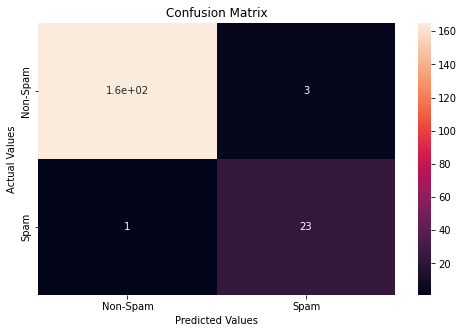

[[array(['Non-Spam'], dtype='<U8'),
  'Somebody set up a website where you can play hold em using eve online spacebucks',
  array(['Spam'], dtype='<U8')],
 [array(['Non-Spam'], dtype='<U8'),
  'I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;',
  array(['Spam'], dtype='<U8')],
 [array(['Non-Spam'], dtype='<U8'),
  'My slave! I want you to take 2 or 3 pictures of yourself today in bright light on your cell phone! Bright light!',
  array(['Spam'], dtype='<U8')],
 [array(['Spam'], dtype='<U8'),
  'Cashbin.co.uk (Get lots of cash this weekend!) www.cashbin.co.uk Dear Welcome to the weekend We have got our biggest and best EVER cash give away!! These..',
  array(['Non-Spam'], dtype='<U8')]]

In [18]:
calc_confusion_matrix(df_validation)

In [19]:
def print_confusion_on_datapoint(data_point):
    print("True label: ", data_point[0])
    print("Text: ", data_point[1])
    print("Predicted label: ", data_point[2])

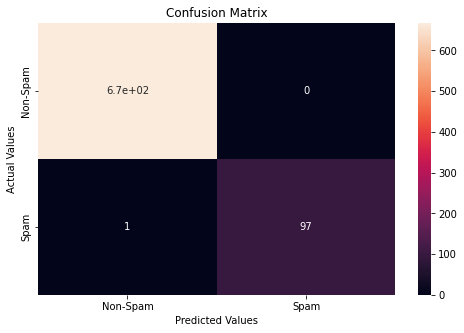

True label:  ['Spam']
Text:  Latest News! Police station toilet stolen, cops have nothing to go on!
Predicted label:  ['Non-Spam']






In [20]:
from pprint import pprint
VERBOSE = False
wrong_classifications_result = calc_confusion_matrix(TRAINING_DATASET)
[print_confusion_on_datapoint(data_point) for data_point in wrong_classifications_result if data_point[0] == 'Spam']
print("\n")
[print_confusion_on_datapoint(data_point) for data_point in wrong_classifications_result if data_point[0] == 'Non-Spam']
print("\n")

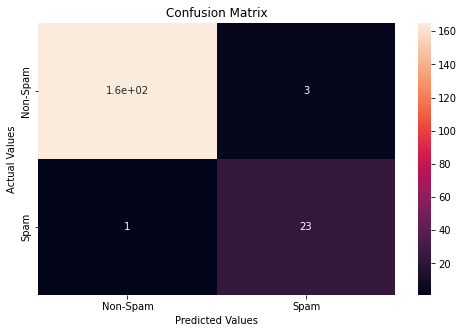

True label:  ['Spam']
Text:  Cashbin.co.uk (Get lots of cash this weekend!) www.cashbin.co.uk Dear Welcome to the weekend We have got our biggest and best EVER cash give away!! These..
Predicted label:  ['Non-Spam']


True label:  ['Non-Spam']
Text:  My slave! I want you to take 2 or 3 pictures of yourself today in bright light on your cell phone! Bright light!
Predicted label:  ['Spam']
True label:  ['Non-Spam']
Text:  Somebody set up a website where you can play hold em using eve online spacebucks
Predicted label:  ['Spam']
True label:  ['Non-Spam']
Text:  I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
Predicted label:  ['Spam']




In [21]:
from pprint import pprint
VERBOSE = False
wrong_classifications_result = calc_confusion_matrix(df_validation)
[print_confusion_on_datapoint(data_point) for data_point in wrong_classifications_result if data_point[0] == 'Spam']
print("\n")
[print_confusion_on_datapoint(data_point) for data_point in wrong_classifications_result if data_point[0] == 'Non-Spam']
print("\n")

In [22]:
total_correct, total_count = calculate_accuracy(df_test)
print(f'Accuracy on testing data: {total_correct*100 / total_count:.2f}%.')

Accuracy on testing data: 97.60%.


All the work above was to train the model. Now that it is trained, we can use it to actually solve the task, by inputting a new sentence and have the model say what sentiment it is!

In [23]:
def make_predictions_from_model(sentences):
  inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
  output = net(**inputs)
  tensor_in_cpu = output.cpu().data.numpy().argmax(axis = 1)
  inference_labels = enc.inverse_transform(tensor_in_cpu)
  return inference_labels